# Week 7

**Table of Contents**

-   [Spark](#spark)
    -   [Architecture](#architecture)
    -   [Cluster Creation](#cluster)
    -   [Spark Basics](#basics)
    -   [City Bike Demonstration](#demo) 

<a id='spark'></a>
## Spark

[Apache Spark](https://spark.apache.org/) is an in-memory, distributed analytics platform. You can perform SQL operations on structured data inside of Spark with [Spark SQL](https://spark.apache.org/sql/). The Spark platform also includes [Spark MLlib](https://spark.apache.org/mllib/), which is a scalable machine learning library, similar to H2O. In this section, we'll cover some of the basics of Spark architecture and how it can be harnessed to perform machine learning at scale.

<a id='architecture'></a>
### Architecture

The Spark system consists of a *cluster manager*, one or more *worker nodes*, and a *driver program*. The diver program, or application, contains a single *Spark Context*, which is connected to a cluster manager. The cluster manager is responsible for acquiring resources, or executors, for the driver program. The manager also distributes driver program tasks issued by the Spark Context to the executors on the worker nodes. Each executor is its own Java process and it can run tasks in multiple threads. Note that a cluster manager can manage multiple Spark driver programs, or applications, but each application has its own set of executors, which are independent Java processes running on the same worker nodes in the cluster.

Here's a diagram of the architecture described above.

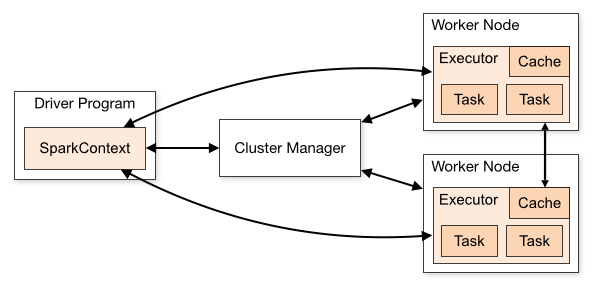

In [1]:
from IPython.display import Image
Image(filename='cluster-overview.png') 

Spark supports an number of different kinds of cluster managers, including [Apache Mesos](https://spark.apache.org/docs/latest/running-on-mesos.html), [Hadoop YARN](https://spark.apache.org/docs/latest/running-on-yarn.html), and [Kubernetes](https://spark.apache.org/docs/latest/running-on-kubernetes.html). We're going to create a [Standalone](https://spark.apache.org/docs/latest/spark-standalone.html) cluster in which the cluster manager is referred to as the *master*. 

<a id='cluster'></a>
### Cluster Creation

Here's an example of a CloudFormation template, which established and configures some of the pieces described above.

```YAML
AWSTemplateFormatVersion: '2010-09-09'
Description: 'Spark Cluster'
Resources:
  SparkMaster:
    Type: 'AWS::EC2::Instance'
    Properties:
      InstanceType: 't2.micro'
      ImageId: 'ami-0ff4fcd0d2b29437e'
      NetworkInterfaces: 
        - DeviceIndex: 0
          GroupSet: 
            - Ref: CS4315Summer2019SecurityGroupSpark
          PrivateIpAddress : '192.168.28.184'
          SubnetId: 'subnet-09e1bc3eb37714763'
      BlockDeviceMappings:
      - DeviceName: '/dev/sda1'
        Ebs:
          VolumeSize: 300
      UserData: 
        Fn::Base64: !Sub |
          #!/bin/bash
          # Resize root volume
          /sbin/resize2fs /dev/sda

          # Install Jupyter Hub Server
          apt-get update
          apt-get -y install python3-pip
          apt-get -y install python3 python-dev python3-dev build-essential libssl-dev libffi-dev libxml2-dev libxslt1-dev zlib1g-dev python-pip
          curl -sL https://deb.nodesource.com/setup_8.x -o nodesource_setup.sh
          bash nodesource_setup.sh
          apt-get -y install nodejs
          hash -r
          npm install -g configurable-http-proxy
          pip3 install jupyterhub
          pip3 install notebook==5.7.4
          # tornado v. 6 is broken
          sudo pip3 uninstall tornado
          sudo pip3 install tornado==5.1.1
          # global install of other python packages
          pip3 install --no-cache-dir pyspark --target /usr/local/lib/python3.5/dist-packages/
          mkdir /srv/jupyterhub # for all security and runtime files
          mkdir /etc/jupyterhub # for all configuration files
          # Set up jupyter hub as a service
          echo "c.JupyterHub.base_url='/'" >> /etc/jupyterhub/jupyterhub_config.py
          echo "c.JupyterHub.port = 80" >> /etc/jupyterhub/jupyterhub_config.py
          printf 'After=syslog.target network.target\n\n[Service]\nUser=root\nExecStart=/usr/local/bin/jupyterhub -f /etc/jupyterhub/jupyterhub_config.py\n\n[Install]\nWantedBy=multi-user.target\n' >> /etc/systemd/system/jupyterhub.service
          systemctl enable jupyterhub.service
          systemctl daemon-reload
          systemctl restart jupyterhub.service
          # User setup
          users="eric.eckstrand"
          for i in $users; do sudo useradd -m -d /home/$i -s /bin/bash $i; done
          for i in $users; do sudo usermod --password $(openssl passwd -1 $i) $i; done

          # Download Java JDK from S3
          apt-get -y update
          apt -y install awscli
          aws s3 cp s3://dsag-java-8/jdk-8u221-linux-x64.tar.gz ./ --region us-east-2 --no-sign-request
          tar -xvf jdk-8u221-linux-x64.tar.gz
          mkdir -p /usr/lib/jvm
          mv ./jdk1.8.0_221 /usr/lib/jvm/
          update-alternatives --install "/usr/bin/java" "java" "/usr/lib/jvm/jdk1.8.0_221/bin/java" 1
          update-alternatives --install "/usr/bin/javac" "javac" "/usr/lib/jvm/jdk1.8.0_221/bin/javac" 1
          chmod a+x /usr/bin/java
          chmod a+x /usr/bin/javac
          chown -R root:root /usr/lib/jvm/jdk1.8.0_221

          # Download Spark and start it up
          wget http://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
          tar xvf spark-2.4.3-bin-hadoop2.7.tgz
          mv spark-2.4.3-bin-hadoop2.7 /usr/local/spark
          cd /usr/local/spark/conf
          cp spark-env.sh.template spark-env.sh
          echo "export SPARK_MASTER_HOST='192.168.28.184'" >> spark-env.sh
          echo "192.168.28.184 master" >> /etc/hosts
          echo "192.168.28.243 worker0" >> /etc/hosts
          echo "worker0" >> /usr/local/spark/conf/slaves
          # Generate ssh key on master copy .ssh/id_rsa.pub to .ssh/authorized_keys on master and workers
          # ssh-keygen -t rsa -P ""
          #cd /usr/local/spark
          #./sbin/start-all.sh
      Tags:
        -
          Key: Name
          Value: SparkMaster
      KeyName: 'CS4315Summer2019-Key-Share'
  SparkWorker:
    Type: 'AWS::EC2::Instance'
    Properties:
      InstanceType: 'a1.2xlarge'
      ImageId: 'ami-0dcd8f62a00af3d76'
      NetworkInterfaces:
      - DeviceIndex: 0
        GroupSet:
        - Ref: CS4315Summer2019SecurityGroupSpark
        PrivateIpAddress : '192.168.28.243'
        SubnetId: 'subnet-09e1bc3eb37714763'
      BlockDeviceMappings:
      - DeviceName: '/dev/sda1'
        Ebs:
          VolumeSize: 300
      UserData:
        Fn::Base64: !Sub |
          #!/bin/bash
          # Resize root volume
          /sbin/resize2fs /dev/sda

          # Download Java JDK from S3
          apt-get -y update
          apt -y install awscli
          aws s3 cp s3://dsag-java-8/jdk-8u221-linux-arm64-vfp-hflt.tar.gz ./ --region us-east-2 --no-sign-request
          tar -xvf jdk-8u221-linux-arm64-vfp-hflt.tar.gz
          mkdir -p /usr/lib/jvm
          mv ./jdk1.8.0_221 /usr/lib/jvm/
          update-alternatives --install "/usr/bin/java" "java" "/usr/lib/jvm/jdk1.8.0_221/bin/java" 1
          update-alternatives --install "/usr/bin/javac" "javac" "/usr/lib/jvm/jdk1.8.0_221/bin/javac" 1
          chmod a+x /usr/bin/java
          chmod a+x /usr/bin/javac
          chown -R root:root /usr/lib/jvm/jdk1.8.0_221

          # User setup
          users="eric.eckstrand"
          for i in $users; do sudo useradd -m -d /home/$i -s /bin/bash $i; done
          for i in $users; do sudo usermod --password $(openssl passwd -1 $i) $i; done

          # Download Spark and start it up
          wget http://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
          tar xvf spark-2.4.3-bin-hadoop2.7.tgz
          mv spark-2.4.3-bin-hadoop2.7 /usr/local/spark
          echo "192.168.28.184 master" >> /etc/hosts
          echo "192.168.28.243 worker0" >> /etc/hosts
      Tags:
      -
        Key: Name
        Value: SparkWorker
      KeyName: 'CS4315Summer2019-Key-Share'
  SparkMasterEIPAssociation:
    Type: AWS::EC2::EIPAssociation
    Properties:
      AllocationId: 'eipalloc-0ca4e9b51d3067367'
      InstanceId: !Ref SparkMaster
  SparkWorkerEIPAssociation:
    Type: AWS::EC2::EIPAssociation
    Properties:
      AllocationId: 'eipalloc-03094dec1dd9465cc'
      InstanceId: !Ref SparkWorker
  CS4315Summer2019SecurityGroupSpark:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: Inbound and outbound rules for Spark Node
      SecurityGroupEgress:
      - CidrIp: '0.0.0.0/0'
        Description: All
        FromPort: 0
        IpProtocol: tcp
        ToPort: 65535
      SecurityGroupIngress:
      - CidrIp: '0.0.0.0/0'
        Description: All
        FromPort: 0
        IpProtocol: tcp
        ToPort: 65535
      Tags:
      - Key: Name
        Value: 'CS4315Summer2019-Spark'
      VpcId: 'vpc-00b2b0d347ea0e3cc'
```

Once this has been established, we can create our Spark Context and connect to the master, or cluster manager. We'll use the [pyspark](https://spark.apache.org/docs/latest/api/python/index.html) python package to interact with the spark cluster in this demonstration.

In [2]:
from pyspark import SparkConf, SparkContext

In [3]:
conf = SparkConf().setAppName('pyspark').setMaster('spark://192.168.28.184:7077').set("spark.driver.host", "192.168.28.184");
sc = SparkContext(conf=conf)

We can work with structured data (i.e. ingest CSVs) with [SQLContext](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext), which is a wrapper around the SparkContext.

In [4]:
from pyspark import SQLContext
sqlc = SQLContext(sc)

<a id='basics'></a>
### Spark Basics

Like the Pandas DataFrame, or the H2O Frame, the Spark [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) is a convenient in-memory data structure that can be used to conduct data analysis.  

Spark supports multiple connectors to persisted data sources, but we can demonstrate how to ingest CSV files into a Spark cluster. Of note, like we saw with H2O, the CSV in question must reside in the same path on each of the nodes in the cluster.

In [5]:
df_iris = sqlc.read.csv("/home/eric.eckstrand/iris.csv")

In [6]:
df_iris.take(10)

[Row(_c0='Sepal.Length', _c1='Sepal.Width', _c2='Petal.Length', _c3='Petal.Width', _c4='Species'),
 Row(_c0='5.1', _c1='3.5', _c2='1.4', _c3='0.2', _c4='setosa'),
 Row(_c0='4.9', _c1='3', _c2='1.4', _c3='0.2', _c4='setosa'),
 Row(_c0='4.7', _c1='3.2', _c2='1.3', _c3='0.2', _c4='setosa'),
 Row(_c0='4.6', _c1='3.1', _c2='1.5', _c3='0.2', _c4='setosa'),
 Row(_c0='5', _c1='3.6', _c2='1.4', _c3='0.2', _c4='setosa'),
 Row(_c0='5.4', _c1='3.9', _c2='1.7', _c3='0.4', _c4='setosa'),
 Row(_c0='4.6', _c1='3.4', _c2='1.4', _c3='0.3', _c4='setosa'),
 Row(_c0='5', _c1='3.4', _c2='1.5', _c3='0.2', _c4='setosa'),
 Row(_c0='4.4', _c1='2.9', _c2='1.4', _c3='0.2', _c4='setosa')]

In [7]:
type(df_iris)

pyspark.sql.dataframe.DataFrame

<a id='demo'></a>
### City Bike Demonstration

In [8]:
df_bikes = sqlc.read.csv("/home/eric.eckstrand/20*.csv", header="true", inferSchema="true")

In [9]:
df_bikes.printSchema()

root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start station name: string (nullable = true)
 |-- start station latitude: double (nullable = true)
 |-- start station longitude: double (nullable = true)
 |-- end station id: integer (nullable = true)
 |-- end station name: string (nullable = true)
 |-- end station latitude: double (nullable = true)
 |-- end station longitude: double (nullable = true)
 |-- bikeid: integer (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth year: string (nullable = true)
 |-- gender: integer (nullable = true)



In [10]:
df_bikes.columns

['tripduration',
 'starttime',
 'stoptime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'usertype',
 'birth year',
 'gender']

In [12]:
df_bikes.select('tripduration','start station name','starttime').show(10)

+------------+--------------------+-------------------+
|tripduration|  start station name|          starttime|
+------------+--------------------+-------------------+
|         404|     E 23 St & 1 Ave|2014-07-01 00:00:04|
|         850|Bank St & Washing...|2014-07-01 00:00:06|
|        1550|     W 13 St & 7 Ave|2014-07-01 00:00:21|
|         397|Spruce St & Nassa...|2014-07-01 00:00:29|
|         609| Bank St & Hudson St|2014-07-01 00:00:37|
|        2245|Cumberland St & L...|2014-07-01 00:01:09|
|        1323| FDR Drive & E 35 St|2014-07-01 00:01:15|
|         320| E 16 St & Irving Pl|2014-07-01 00:01:16|
|        2430|  Broadway & W 53 St|2014-07-01 00:01:18|
|         700|Leonard St & Chur...|2014-07-01 00:01:21|
+------------+--------------------+-------------------+
only showing top 10 rows



In [13]:
print("{0} rows x {1} columns".format(df_bikes.count(), len(df_bikes.columns)))

10407546 rows x 15 columns


Let's convert the `starttime` column from a date to a numeric value of days since the Epoch (January 1, 1970 midnight UTC/GMT), and we'll call it `Days`. We'll use the [withColumn](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn) function to achieve this.

In [14]:
from pyspark.sql.functions import floor 
secsPerDay = 3600 * 24
df_bikes = df_bikes.withColumn("Days", floor(df_bikes.starttime.cast("long") / secsPerDay))
df_bikes.select('starttime', 'Days').show(10)

+-------------------+-----+
|          starttime| Days|
+-------------------+-----+
|2014-07-01 00:00:04|16252|
|2014-07-01 00:00:06|16252|
|2014-07-01 00:00:21|16252|
|2014-07-01 00:00:29|16252|
|2014-07-01 00:00:37|16252|
|2014-07-01 00:01:09|16252|
|2014-07-01 00:01:15|16252|
|2014-07-01 00:01:16|16252|
|2014-07-01 00:01:18|16252|
|2014-07-01 00:01:21|16252|
+-------------------+-----+
only showing top 10 rows



At this point, we have a bunch of individual trips, but we want to know how many trips started from a given station on a given day. To do this we can group all of the individual trips from each station for each day. We can use a [groupBy](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.groupBy) operation to do this.

In [15]:
df_gb = df_bikes.groupBy("Days","start station name")
df_gb

There are a number of functions that we can apply to the resulting groups, including the maximum value of a particular column in the group, or the mean value for a particular column in the group. See the [aggregation methods](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData) for the full set. In our case, we just want the number of entries in a group, or the `count`. Spark will combine the result into an data frame with the columns you grouped by and the result of the (count) function for each row.

In [16]:
df_bikes_per_day = df_gb.count()
df_bikes_per_day.select('Days', 'start station name', 'count').show(10)

+-----+--------------------+-----+
| Days|  start station name|count|
+-----+--------------------+-----+
|16252|Perry St & Bleeck...|   69|
|16253|  Broadway & W 60 St|  144|
|16253|William St & Pine St|   76|
|16253|Central Park S & ...|   81|
|16254|Clinton St & Gran...|   70|
|16257|    W 26 St & 10 Ave|   42|
|16257|Madison St & Mont...|   59|
|16257|  Broadway & W 24 St|  171|
|16257|  Broadway & W 49 St|   86|
|16257|Myrtle Ave & St E...|    8|
+-----+--------------------+-----+
only showing top 10 rows



In [17]:
df_bikes_per_day = df_bikes_per_day.withColumnRenamed("count","bikes")
df_bikes_per_day.select('Days', 'start station name', 'bikes').show(10)

+-----+--------------------+-----+
| Days|  start station name|bikes|
+-----+--------------------+-----+
|16252|Perry St & Bleeck...|   69|
|16253|  Broadway & W 60 St|  144|
|16253|William St & Pine St|   76|
|16253|Central Park S & ...|   81|
|16254|Clinton St & Gran...|   70|
|16257|    W 26 St & 10 Ave|   42|
|16257|Madison St & Mont...|   59|
|16257|  Broadway & W 24 St|  171|
|16257|  Broadway & W 49 St|   86|
|16257|Myrtle Ave & St E...|    8|
+-----+--------------------+-----+
only showing top 10 rows



In [18]:
print("{0} rows x {1} columns".format(df_bikes_per_day.count(), len(df_bikes_per_day.columns)))

138795 rows x 3 columns


So, we'll treat the `bikes` columns as our response, or the column that we want to predict. This is a regression problem. 

Let's extract a couple extra features from the `Days` column. Perhaps it's beneficial to know the month of the year and the day of the week. Maybe this gives the modeling technology some more predictive power. 

In [20]:
from pyspark.sql.functions import from_unixtime
df_bikes_per_day = df_bikes_per_day.withColumn("Month", from_unixtime(df_bikes_per_day.Days*secsPerDay, format='MMM'))
df_bikes_per_day = df_bikes_per_day.withColumn("DayOfWeek", from_unixtime(df_bikes_per_day.Days*secsPerDay, format='EEE'))

In [21]:
df_bikes_per_day.select('Days', 'start station name', 'bikes', 'Month', 'DayOfWeek').show(10)

+-----+--------------------+-----+-----+---------+
| Days|  start station name|bikes|Month|DayOfWeek|
+-----+--------------------+-----+-----+---------+
|16252|Perry St & Bleeck...|   69|  Jul|      Tue|
|16253|  Broadway & W 60 St|  144|  Jul|      Wed|
|16253|William St & Pine St|   76|  Jul|      Wed|
|16253|Central Park S & ...|   81|  Jul|      Wed|
|16254|Clinton St & Gran...|   70|  Jul|      Thu|
|16257|    W 26 St & 10 Ave|   42|  Jul|      Sun|
|16257|Madison St & Mont...|   59|  Jul|      Sun|
|16257|  Broadway & W 24 St|  171|  Jul|      Sun|
|16257|  Broadway & W 49 St|   86|  Jul|      Sun|
|16257|Myrtle Ave & St E...|    8|  Jul|      Sun|
+-----+--------------------+-----+-----+---------+
only showing top 10 rows



Let's build a regression model using random forest.

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [34]:
cat_cols = ["start station name", "Month", "DayOfWeek"]
num_cols = ["Days"]

indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in cat_cols]

encoders = [StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
for indexer in indexers]

assemblerCat = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "cat")

pipelineCat = Pipeline(stages = indexers + encoders + [assemblerCat])
df_bikes_per_day = pipelineCat.fit(df_bikes_per_day).transform(df_bikes_per_day)

assemblerNum = VectorAssembler(inputCols = num_cols, outputCol = "num")

pipelineNum = Pipeline(stages = [assemblerNum])
df_bikes_per_day = pipelineNum.fit(df_bikes_per_day).transform(df_bikes_per_day)

assembler = VectorAssembler(inputCols = ["cat", "num"], outputCol = "features")

pipeline = Pipeline(stages = [assembler])
df_bikes_per_day = pipeline.fit(df_bikes_per_day).transform(df_bikes_per_day)
df_bikes_per_day.select('features', 'bikes').show(10)

+--------------------+-----+
|            features|bikes|
+--------------------+-----+
|[175.0,0.0,1.0,16...|   69|
|[54.0,0.0,3.0,162...|  144|
|[105.0,0.0,3.0,16...|   76|
|[220.0,0.0,3.0,16...|   81|
|[114.0,0.0,4.0,16...|   70|
|[41.0,0.0,5.0,162...|   42|
|[5.0,0.0,5.0,1625...|   59|
|[196.0,0.0,5.0,16...|  171|
|[277.0,0.0,5.0,16...|   86|
|[255.0,0.0,5.0,16...|    8|
+--------------------+-----+
only showing top 10 rows



In [35]:
df_bikes_per_day.select("start station name").distinct().count()

340

In [51]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=500).fit(df_bikes_per_day)

Let's split the training data into training and test sets using the [randomSplit](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) function. We're not going to do any hyper-parameter tuning today, but you should.

In [52]:
(train, test) = df_bikes_per_day.randomSplit([0.8, 0.2])

In [53]:
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol="bikes", maxBins=500)

In [54]:
pipeline = Pipeline(stages=[featureIndexer, rf])

In [55]:
model = pipeline.fit(train)

In [56]:
predictions = model.transform(test)

In [57]:
predictions.select("prediction", "bikes", "features").show(5)

+------------------+-----+--------------------+
|        prediction|bikes|            features|
+------------------+-----+--------------------+
| 70.64071381148214|   50|[15.0,0.0,1.0,158...|
| 86.15073243322503|   69|[21.0,0.0,6.0,158...|
|110.32726419243161|  119|[18.0,0.0,4.0,158...|
| 19.43954754953519|   15|[285.0,0.0,2.0,15...|
|20.569077061549503|   15|[236.0,0.0,2.0,15...|
+------------------+-----+--------------------+
only showing top 5 rows



In [58]:
evaluator = RegressionEvaluator(labelCol="bikes", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 29.6577


In [60]:
29.6577**2

879.5791692899999